In [10]:
%matplotlib inline
import math
from decimal import *
import numpy as np # linear algebra
import pandas as pd # read_csv and such
import matplotlib.pyplot as plt # plotting and such
from geopy.distance import vincenty # calculate distance between locations
from io import StringIO # convert strings to buffers or something like that.
import seaborn as sns

### Get the data and start messing with it

In [2]:
# the paths to our flight related data sets
airlines_path = '../data/flight_delays_2015/airlines.csv'
airports_path = '../data/flight_delays_2015/airports.csv'
flights_path  = '../data/flight_delays_2015/flights.csv'
# weather related paths
weather_path = '../data/weather/2015.csv'
stations_path  = '../data/weather/stations.csv'

# read the airlines in and get a dataframe containing the dataset
# Set low_memory to False so that types can be inferred/converted
airlines_df = pd.read_csv(airlines_path, low_memory=False) 
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [3]:
airports_df = pd.read_csv(airports_path, low_memory=False)
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
flights_df = pd.read_csv(flights_path, low_memory=False)
flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
stations_df = pd.read_csv(stations_path, low_memory=False)
stations_df.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,7011,99999,CWOS 07011,NaN,NaN,NaN,NaN,NaN,NaN,20120101,20121129
1,7025,99999,CWOS 07025,NaN,NaN,NaN,NaN,NaN,NaN,20120127,20120127
2,7034,99999,CWOS 07034,NaN,NaN,NaN,NaN,NaN,NaN,20121024,20121106
3,7047,99999,CWOS 07047,NaN,NaN,NaN,NaN,NaN,NaN,20120613,20120717
4,7059,99999,CWOS 07059,NaN,NaN,NaN,NaN,NaN,NaN,20120314,20120828


### We have to do some cleaning of the dataset
You can see that some of the data points in the flights dataset come in as NaN.
This is because the CSV file contains some points of data which are `''`.
We will have to process these as a 0 when doing maths on the delay times.

### Types of delays
Each flight's total delay time is a summation of the columns;
`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`

### Remove stations that are not in the US or are missing latitude/longitude

In [7]:
stations_df = stations_df[np.isfinite(stations_df['lat'])]
stations_df = stations_df[np.isfinite(stations_df['lon'])]
stations_df = stations_df[stations_df['country'] == 'US']
stations_df.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
6523,619760,99999,SERGE-FROLOW (ILE TROMELIN),US,NaN,NaN,-15.883,54.517,13.0,19730101,20170916
6540,621010,99999,MOORED BUOY,US,NaN,NaN,50.600,-2.933,-999.0,20080721,20080721
6541,621110,99999,MOORED BUOY,US,NaN,NaN,58.900,-0.200,-999.0,20041118,20091201
6542,621160,99999,MOORED BUOY,US,NaN,NaN,58.100,1.800,-999.0,20040829,20050929
6543,621170,99999,MOORED BUOY,US,NaN,NaN,57.900,0.100,-999.0,20040726,20110809


### Assign each airport primary and secondary weather stations
Choose two closest weather stations to assign to each airport

In [10]:
for index, row in airports_df.iterrows():
    first = stations_df.iloc[0]
    first_dist = vincenty((row['LATITUDE'], row['LONGITUDE']), (first['lat'], first['lon'])).miles
    second = stations_df.iloc[1]
    second_dist = vincenty((row['LATITUDE'], row['LONGITUDE']), (second['lat'], second['lon'])).miles
    if second_dist < first_dist:
        first, first_dist, second, second_dist = second, second_dist, first, first_dist
    for i in range(2, len(stations_df['usaf'])):
        dist = vincenty((row['LATITUDE'], row['LONGITUDE']), (stations_df.iloc[i]['lat'], stations_df.iloc[i]['lon'])).miles
        if dist < second_dist:
            if dist < first_dist:
                first, first_dist, second, second_dist = stations_df.iloc[i], dist, first, first_dist
            else:
                second, second_dist = stations_df.iloc[i], dist
    airports_df.loc[index, 'primary_station_usaf'], airports_df.loc[index, 'primary_station_wban'], airports_df.loc[index, 'secondary_station_usaf'], airports_df.loc[index, 'secondary_station_wban'] = first['usaf'], first['wban'], second['usaf'], second['wban']
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,primary_station_usaf,primary_station_wban,secondary_station_usaf,secondary_station_wban
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040,725170.0,14737.0,999999.0,14737.0
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190,722660.0,13962.0,690190.0,99999.0
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919,723650.0,23050.0,999999.0,23050.0
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183,726590.0,14929.0,999999.0,14929.0
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447,722160.0,13869.0,999999.0,13869.0


# Correlation Analysis of 2015 Flight Delays
---
We want to do a simple correlation analysis of the flight dataset, and produce a heatmap of the variable correlaitons.

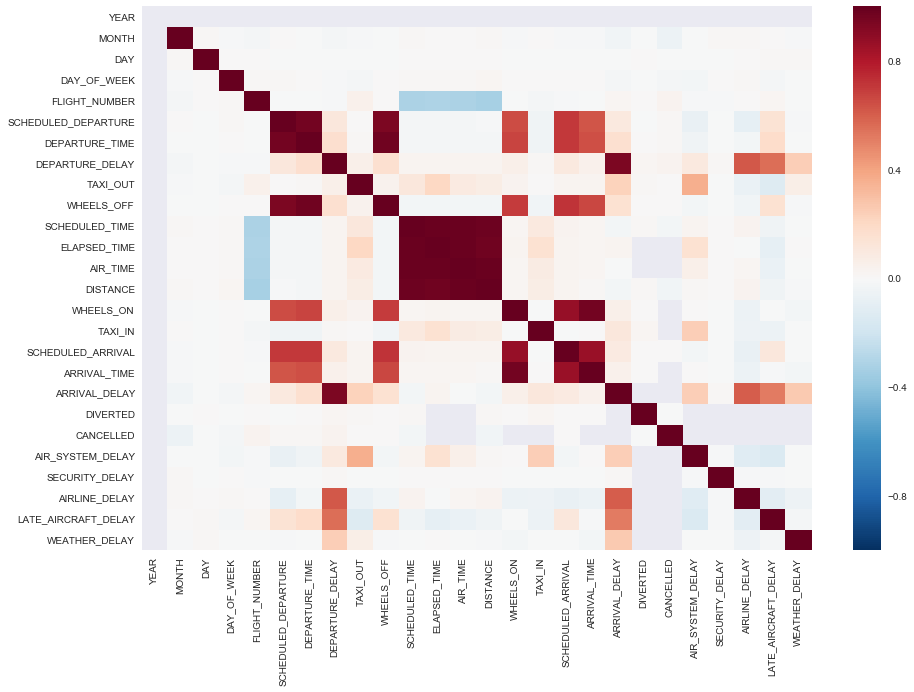

In [11]:
corr = flights_df.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           ax=ax)